In [54]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm

### Stable Coin 제거

In [ ]:
mktcap_screened = pd.read_pickle("clean_mktcap.pickle")
price_screened = pd.read_pickle("clean_price.pickle")

pct_screened = price_screened.pct_change()

# 시총 weight 데이터프레임 생성
mktcap_weight = mktcap_screened.apply(lambda x: x / np.nansum(x), axis=1)

mktcap_weight.loc[:,["BTC","ETH"]].plot(figsize=(24,12));

In [ ]:
stable_coin = ["USDT","USDC","BUSD","DAI","TUSD","FRAX",
               "USDP","USDD","GUSD","FEI","USDJ","LUSD",
               "USTC","EURS","TRIBE","vUSDC","USDX",
               "vBUSD","XSGD","VAI","SUSD","CUSD","SBD",
               "vUSDT","EUROC","OUSD","USDK","RSV","KRT",
               "GYEN","CEUR","HUSD","BIDR","IDRT","vDAI",
               "DGD","BITCNY","XCHF","DGX","EOSDT","BITUSD",
               "ZUSD","ESD","USDS","BAC","ALUSD","YUSD",
               "USX","MIM","DOLA","MIMATIC","EURT","MUSD",
               "USDs","AGEUR","mCUSD","TOR","TRYB","mCEUR",
               "XIDR","1GOLD","USDS","MXNT","XSTUSD","USDEX",
               "CUSD","MTR","BRCP","CUSDT","SEUR","xDAI",
               "DUSD","USDP","USDH","USDZ","DJED","JPYC",
               "PAR","WANUSDT","ONC","FUSD","MUSD","ONEICHI",
               "FUSD","CADC","XUSD","DSD","JPYC","USDB","XUSD",
               "MONEY","USDR","COFFIN","IRON","KBC","DPT","nUSD",
               "STATIK","USN","USNBT","BITGOLD","BITEUR","HGT",
               "QC","ITL","CONST","USDQ","XEUR","BGBP","EBASE",
               "BKRW","USDEX","USDL","UETH","BVND","BSD","SAC",
               "USDEX","ZUSD","USDFL","MDS","MDO","FLOAT","fUSDT",
               "FLUSD","ARTH","USDAP","BEAN","COUSD","DUSD","AUSD",
               "fUSDT","H2O","IUSDS","USDI","GBPT","EUROS"]

len(stable_coin)

In [ ]:
symbol = mktcap_weight.columns.to_list()

in_symbol = [stable for stable in stable_coin if stable in symbol]

# 우리 데이터 프레임에도 있는 코인은 여기에 들어가게 됨
print(len(in_symbol))

In [ ]:
# 스테이블코인 을 드랍하자
mkt = mktcap_screened.drop(in_symbol, axis=1)
price = price_screened.drop(in_symbol, axis=1)

mkt.to_pickle("mktcap_without_stable.pickle")
price.to_pickle("price_without_stable.pickle")

### Returns을 찍어보자

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from statsmodels.api import OLS, add_constant
from scipy.stats import stats

In [2]:
mktcap = pd.read_pickle("mktcap_without_stable.pickle").drop("RISE2", axis=1)
price  = pd.read_pickle("price_without_stable.pickle").drop("RISE2", axis=1)

In [3]:
# pct를 구해줌
pct = price.pct_change(fill_method=None)
pct_weekly = price.pct_change(7, fill_method=None) \
                  .resample("W").first()

# 시총, pct의 weekly를 구해줌
weight_daily = mktcap.apply(lambda x: x / np.nansum(x), axis=1)
mktcap_weekly = mktcap.resample("W").first()
weight_weekly = weight_daily.resample("W").first()

# nan처리를 위한 masking 생성
sign_daily = np.sign(price)
sign_weekly = np.sign(price.loc[pct_weekly.index[:-1]])

# masking을 해준 pct_change 데이터프레임을 생성
daily_rtn = sign_daily * pct
weekly_rtn = sign_weekly * pct_weekly

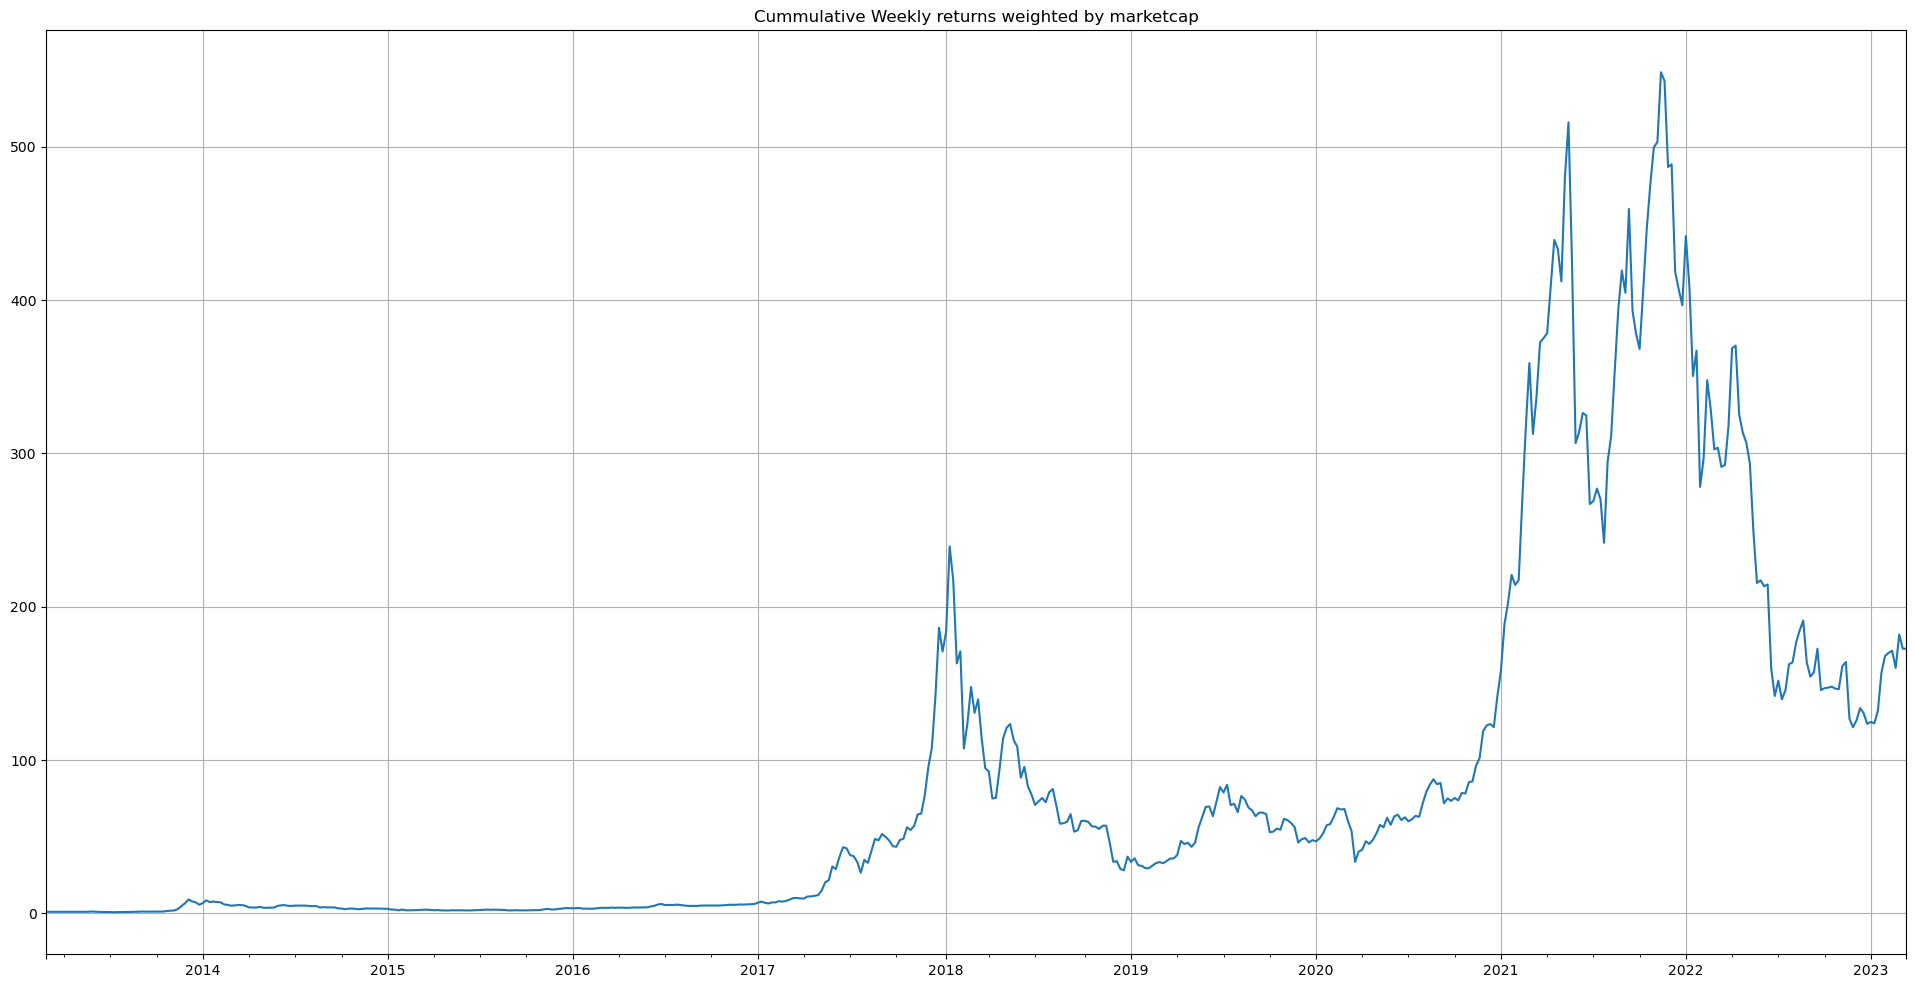

In [4]:
# mktcap 가중평균한 weekly returns
result1 = ((weekly_rtn * weight_weekly.shift(1)).sum(axis=1))
(result1+1).cumprod().plot(figsize=(24,12))
plt.title("Cummulative Weekly returns weighted by marketcap")
plt.grid();

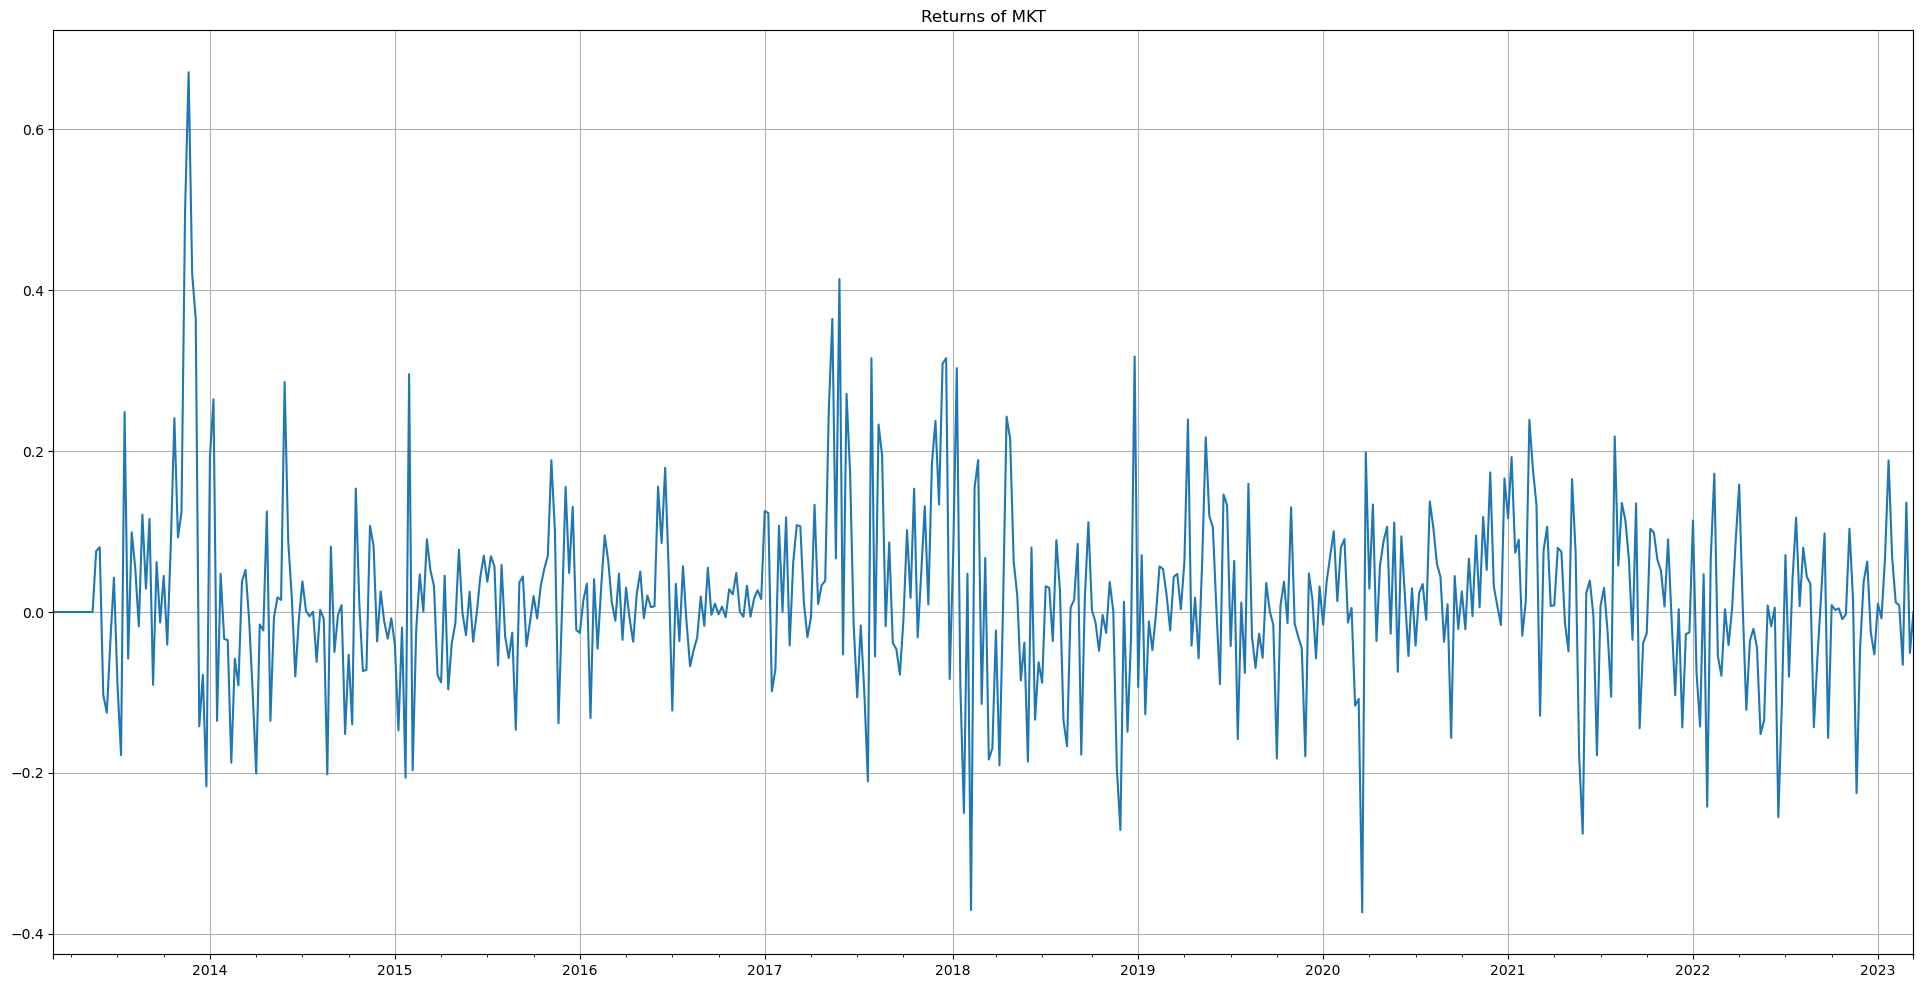

In [5]:
result1.plot(figsize=(24,12))
plt.title("Returns of MKT")
plt.grid();

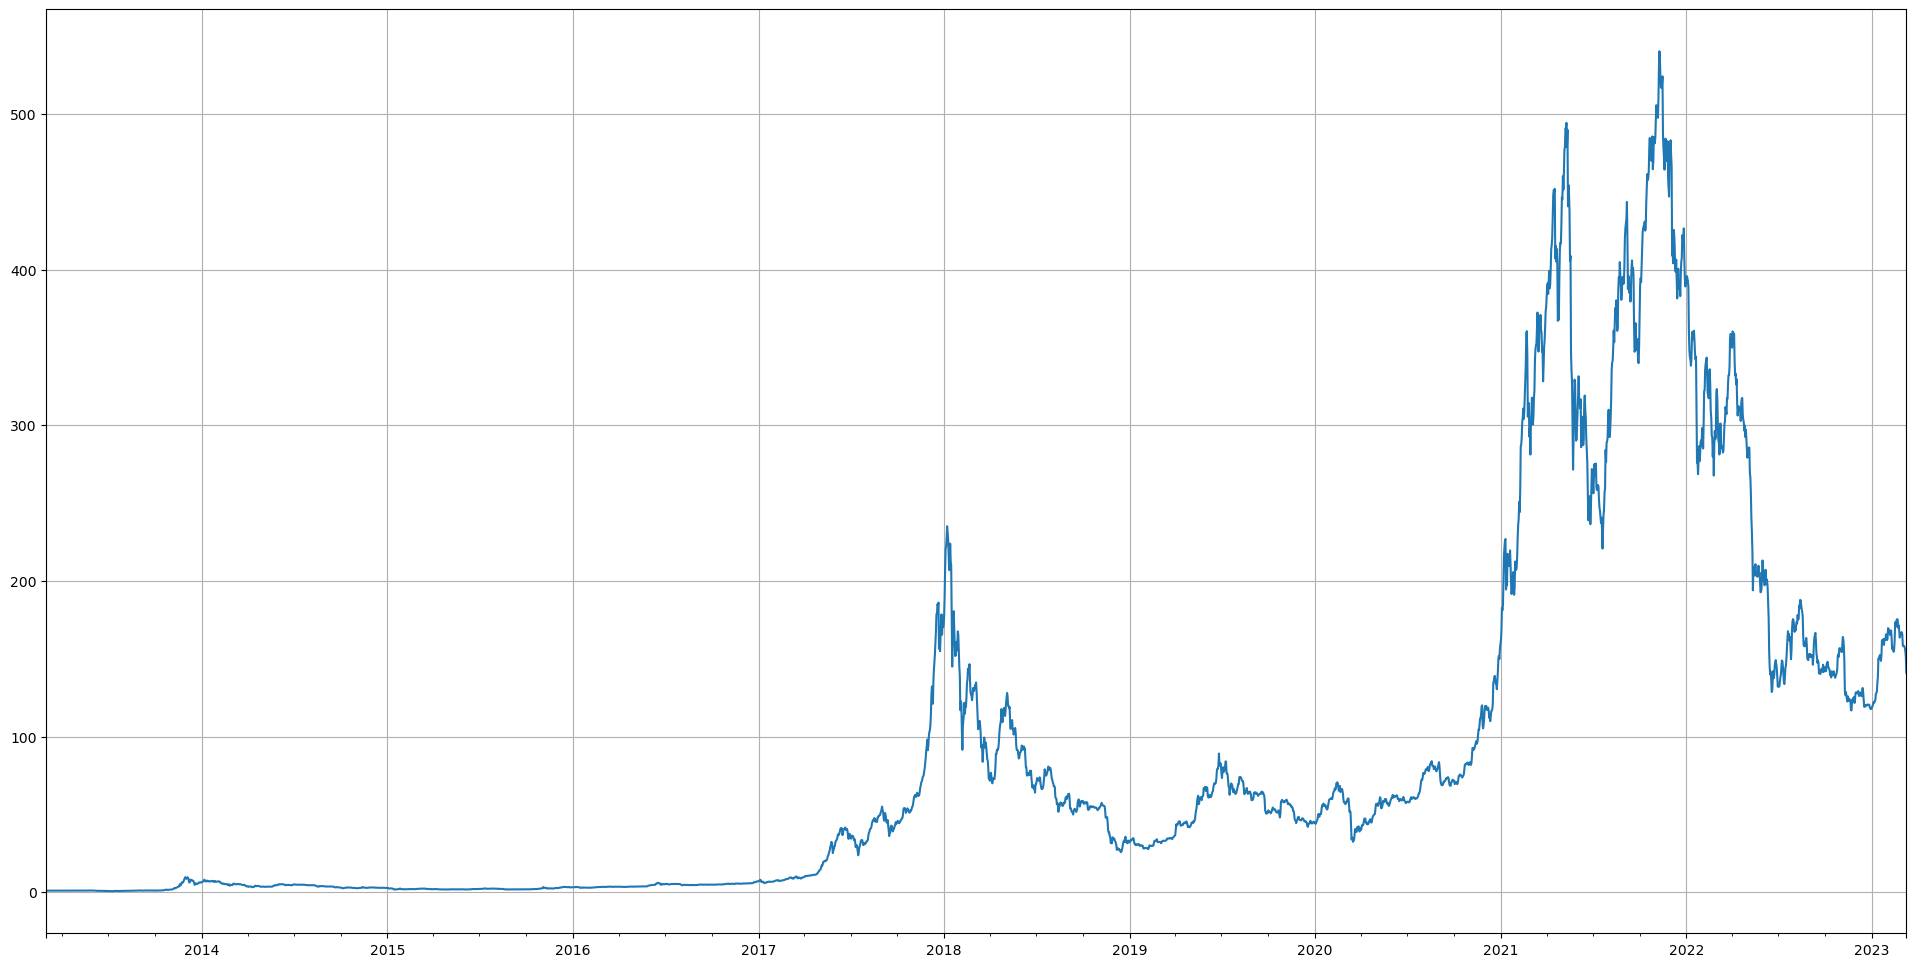

In [6]:
# mktcap으로 가중평균한 daily returns
result2 = ((daily_rtn * weight_daily.shift(1)).sum(axis=1))
(result2+1).cumprod().plot(figsize=(24,12))
plt.grid();

횡단면 회귀를 해보자

weekly_rtn, daily_rtn을 사용

5개의 그룹(모멘텀 기준)

In [7]:
# weekly 모멘텀을 기준으로 5개의 그룹으로 나눈다
thresh = weekly_rtn.apply(lambda x: np.nanquantile(x,[0.2, 0.4, 0.6, 0.8]),
                          axis=1)
t1 = thresh.apply(lambda x: x[0])
t2 = thresh.apply(lambda x: x[1])
t3 = thresh.apply(lambda x: x[2])
t4 = thresh.apply(lambda x: x[3])

# Group별로 True/False를 담고 있다 -> Masking에 사용하면 된다
first = weekly_rtn.apply(lambda x: x <= t1, axis=0) \
                  .replace(True, 1).replace(False, np.nan)
second= weekly_rtn.apply(lambda x: (t1 < x) & (x <= t2), axis=0) \
                  .replace(True, 1).replace(False, np.nan)
third = weekly_rtn.apply(lambda x: (t2 < x) & (x <= t3), axis=0) \
                  .replace(True, 1).replace(False, np.nan)
four =  weekly_rtn.apply(lambda x: (t3 < x) & (x <= t4), axis=0) \
                  .replace(True, 1).replace(False, np.nan)
five =  weekly_rtn.apply(lambda x: x > t4, axis=0) \
                  .replace(True, 1).replace(False, np.nan)

c:\Users\user\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


In [8]:
# 그룹별로 시가총액 weight를 계산
weight_1 = (first * mktcap_weekly).apply(lambda x: x / np.nansum(x), axis=1)
weight_2 = (second * mktcap_weekly).apply(lambda x: x / np.nansum(x), axis=1)
weight_3 = (third * mktcap_weekly).apply(lambda x: x / np.nansum(x), axis=1)
weight_4 = (four * mktcap_weekly).apply(lambda x: x / np.nansum(x), axis=1)
weight_5 = (five * mktcap_weekly).apply(lambda x: x / np.nansum(x), axis=1)

In [9]:
# 분위수 별로 들어가 있는 코인 수를 확인하자
pd.set_option("display.max_rows", 50)

num_coin = pd.concat([first.sum(1), second.sum(1), third.sum(1), 
                      four.sum(1), five.sum(1)], axis=1)

# 횡단면 코인 개수가 그룹별로 20개는 넘는 날짜를 출력하자
slice = num_coin[num_coin > 18].dropna(axis=0)
start_date = slice.index[0]
print(start_date)
slice

2017-05-21 00:00:00


,0,1,2,3,4
2017-05-21,20.0,19.0,19.0,19.0,20.0
2017-05-28,21.0,20.0,21.0,20.0,21.0
2017-06-04,22.0,21.0,22.0,21.0,22.0
2017-06-11,23.0,22.0,23.0,22.0,23.0
2017-06-18,24.0,23.0,24.0,23.0,24.0
...,...,...,...,...,...
2023-02-05,258.0,348.0,166.0,257.0,258.0
2023-02-12,260.0,341.0,178.0,259.0,260.0
2023-02-19,261.0,260.0,261.0,260.0,261.0
2023-02-26,361.0,163.0,262.0,262.0,262.0


In [10]:
# mktcap을 weights로 준 5개 그룹의 return
rtn1 = ((weekly_rtn * weight_1.shift(1)).loc[start_date:].iloc[:-1].sum(1))
rtn2 = ((weekly_rtn * weight_2.shift(1)).loc[start_date:].iloc[:-1].sum(1))
rtn3 = ((weekly_rtn * weight_3.shift(1)).loc[start_date:].iloc[:-1].sum(1))
rtn4 = ((weekly_rtn * weight_4.shift(1)).loc[start_date:].iloc[:-1].sum(1))
rtn5 = ((weekly_rtn * weight_5.shift(1)).loc[start_date:].iloc[:-1].sum(1))

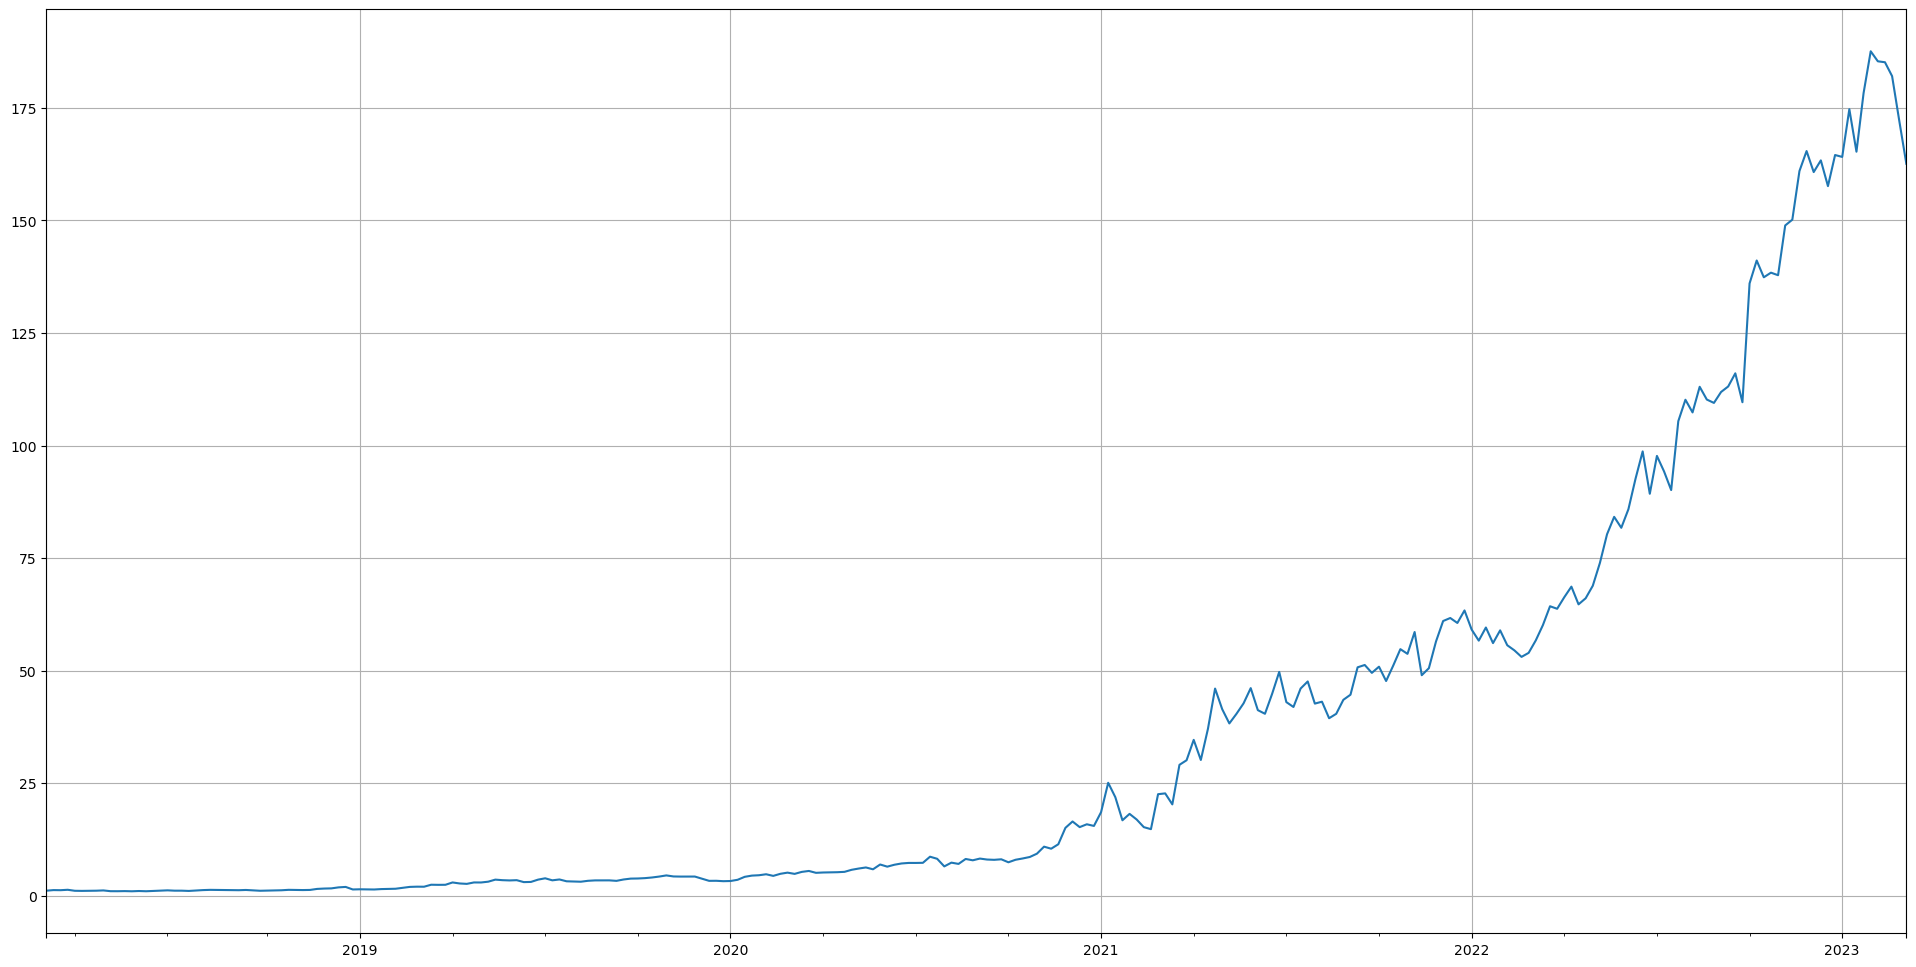

In [37]:
# Q5 - Q1

q5q1 = ((rtn5 - rtn1)).loc["2018-03":]

(q5q1+1).cumprod().plot(figsize=(24,12))
plt.grid();

<AxesSubplot:>

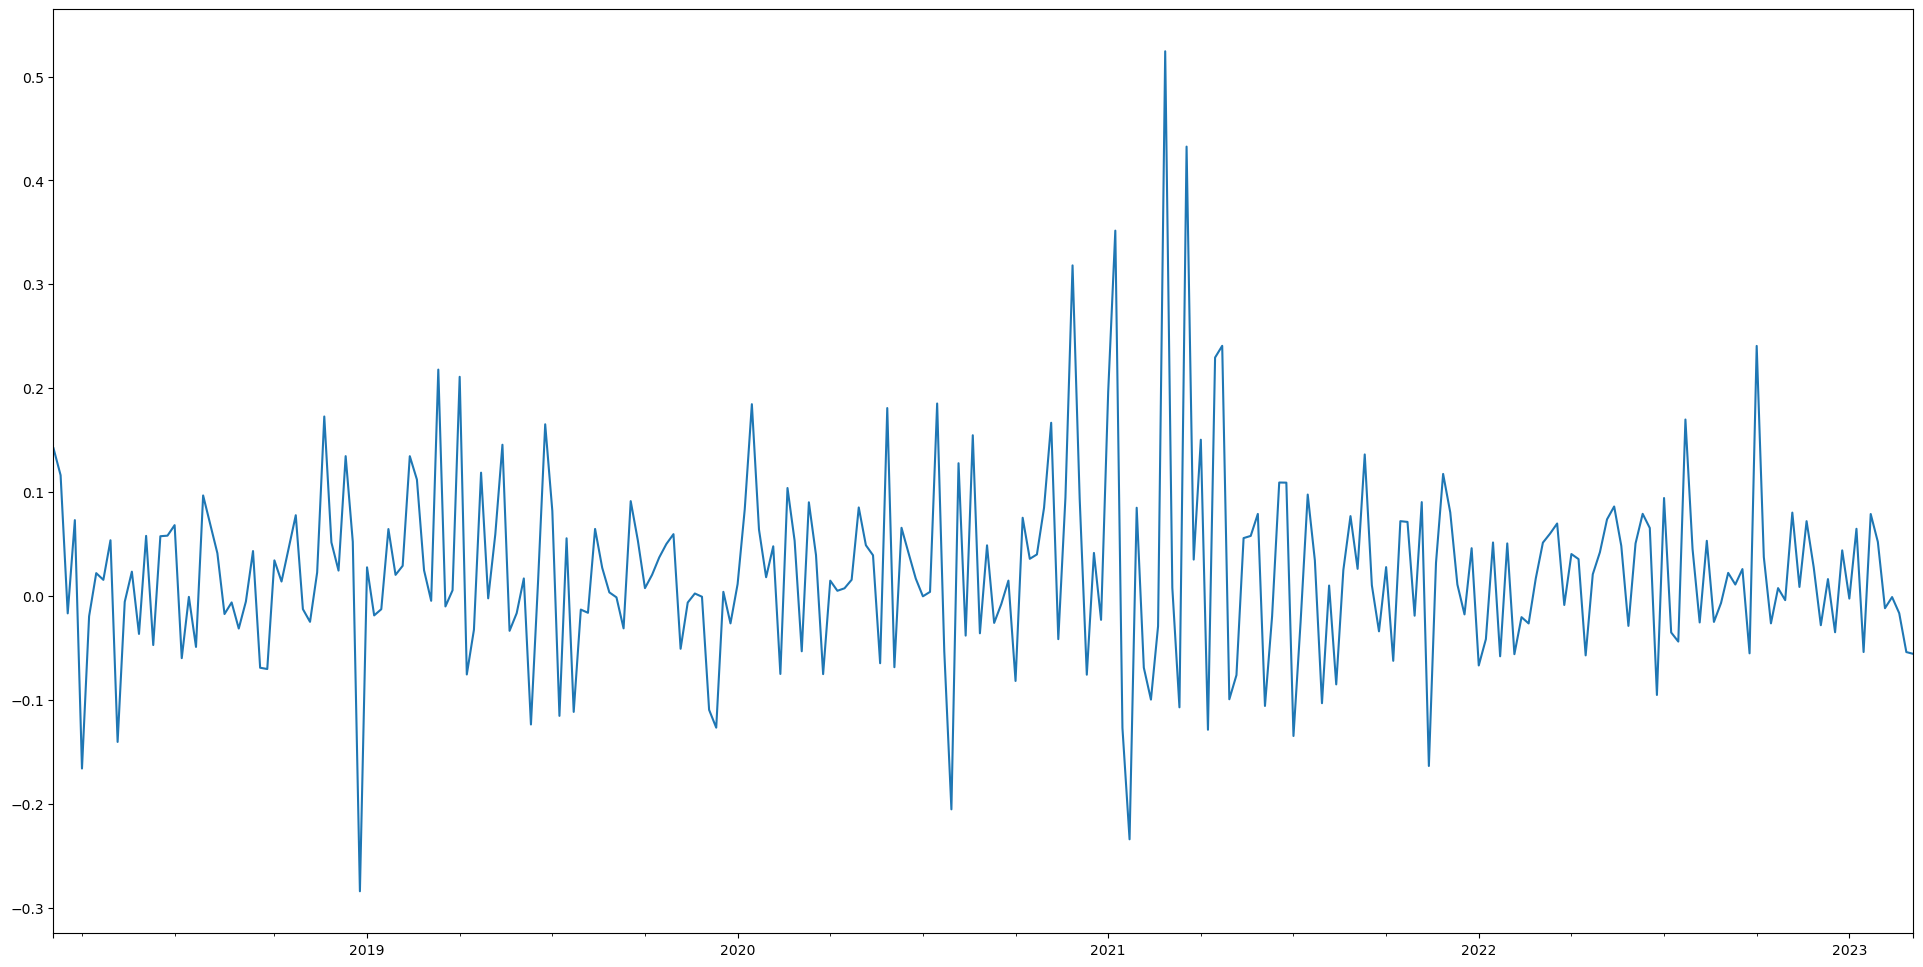

In [38]:
q5q1.plot(figsize=(24,12))

In [39]:
q5q1.mean(), q5q1.std()

(0.023617853293313402, 0.09235412073470882)

In [40]:
stats.ttest_ind(q5q1, np.zeros_like(q5q1.values))

C:\Users\user\AppData\Local\Temp\ipykernel_14432\3313870708.py:1: DeprecationWarning: Please use `ttest_ind` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  stats.ttest_ind(q5q1, np.zeros_like(q5q1.values))


Ttest_indResult(statistic=4.139375151686083, pvalue=4.0600236271290345e-05)

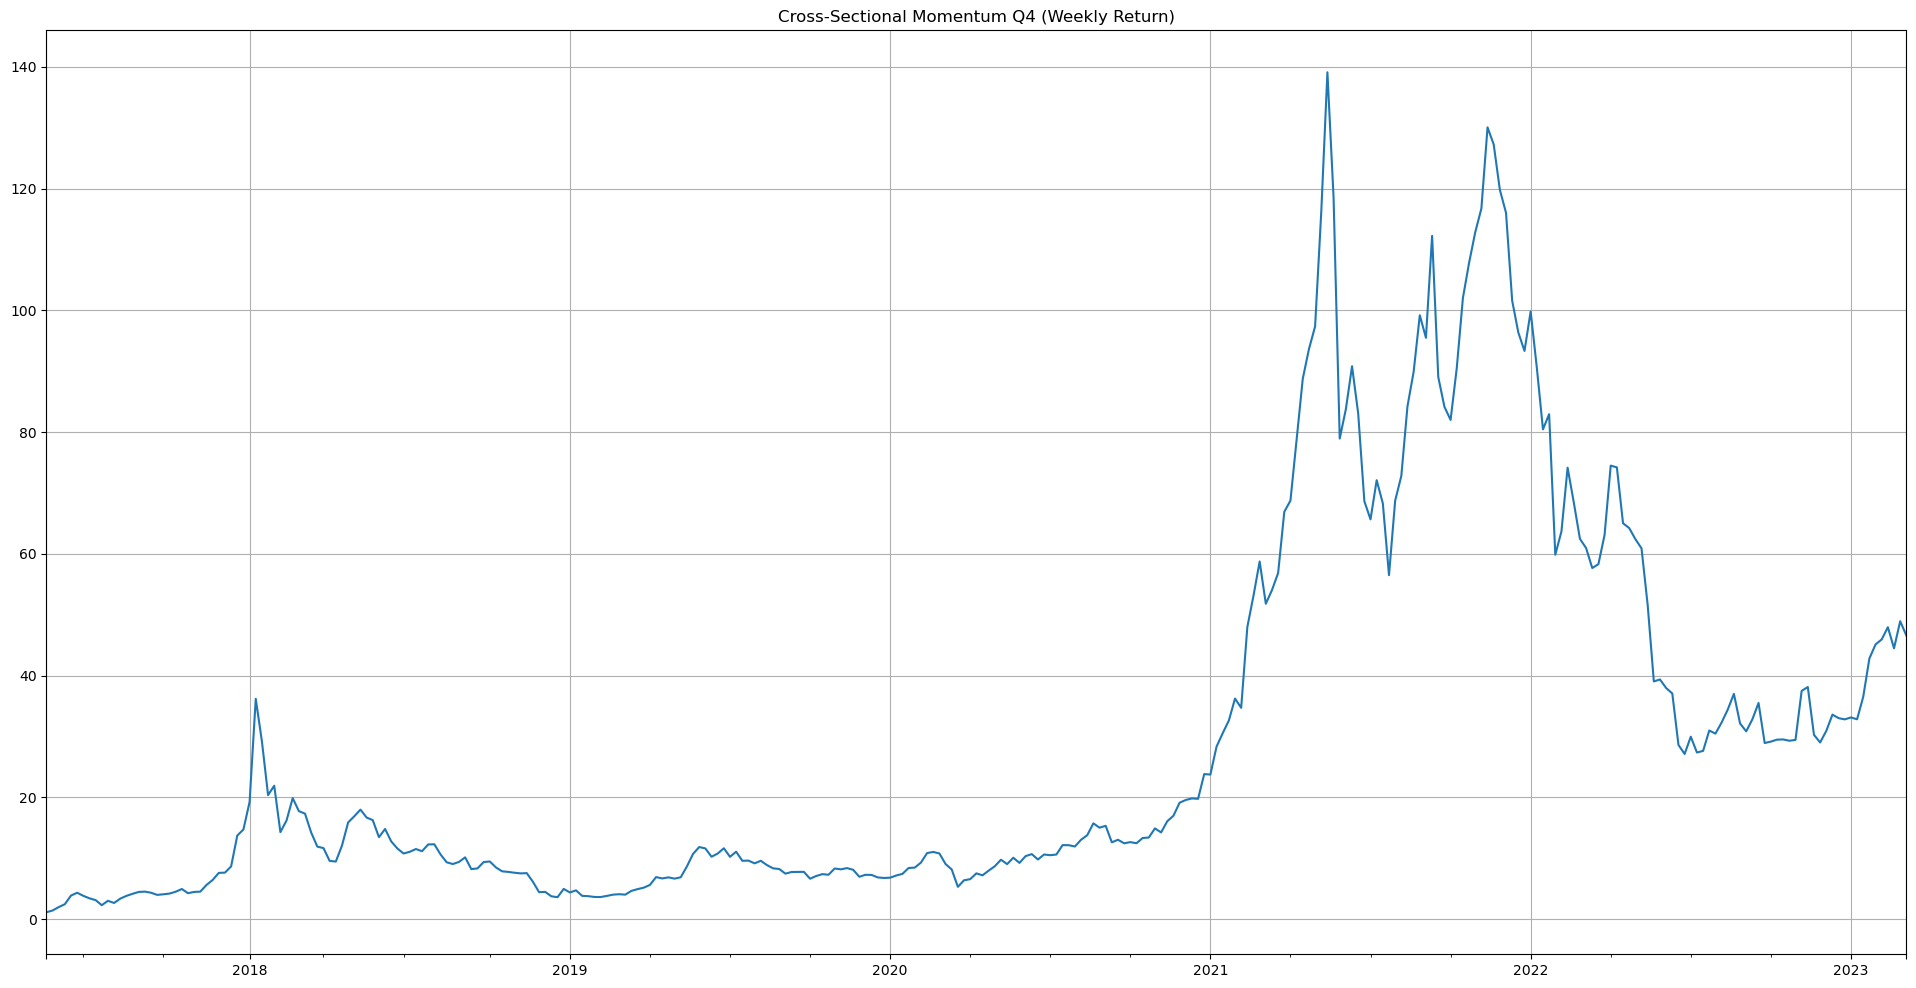

In [11]:
# 리턴 찍어보자
(rtn4 + 1).cumprod().plot(figsize=(24,12))
plt.title("Cross-Sectional Momentum Q4 (Weekly Return)")
plt.grid();

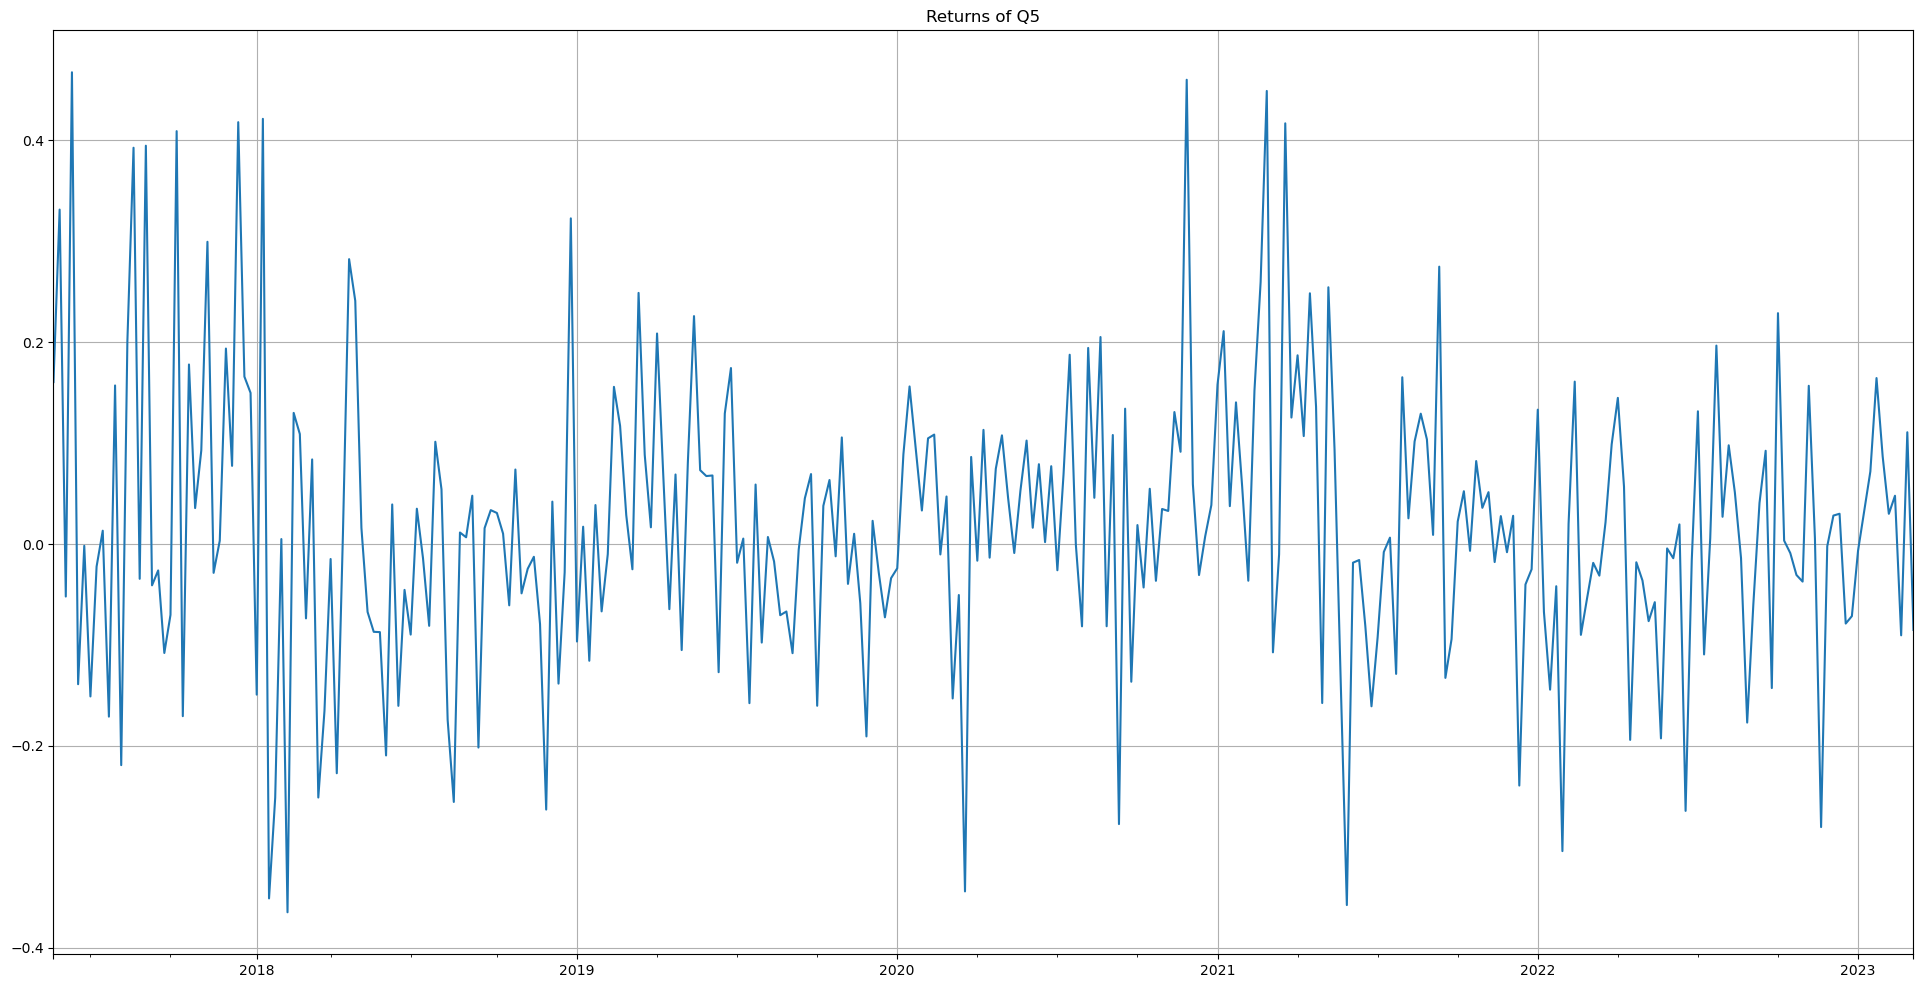

In [12]:
rtn5.plot(figsize=(24,12))
plt.title("Returns of Q5")
plt.grid();

In [13]:
# 3개 분위수로 나눠보자
thresh11 = weekly_rtn.apply(lambda x: np.nanpercentile(x, 33), axis=1)
thresh21 = weekly_rtn.apply(lambda x: np.nanpercentile(x, 66), axis=1)

low = weekly_rtn.apply(lambda x: x < thresh11.values, axis=0)\
                .replace(True, 1).replace(False, np.nan)
middle= weekly_rtn.apply(lambda x: (thresh11.values <= x) & (x < thresh21.values), axis=0) \
                  .replace(True, 1).replace(False, np.nan)
high =  weekly_rtn.apply(lambda x: x >= thresh21.values, axis=0) \
                  .replace(True, 1).replace(False, np.nan)

# 각 그룹별 weights 계산
weight_s = (low * mktcap_weekly).apply(lambda x: x / np.nansum(x), axis=1)
weight_m = (middle * mktcap_weekly).apply(lambda x: x / np.nansum(x), axis=1)
weight_h = (high * mktcap_weekly).apply(lambda x: x / np.nansum(x), axis=1)

c:\Users\user\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
c:\Users\user\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


In [12]:
num_coin2 = pd.concat([low.sum(1),
                       middle.sum(1),
                       high.sum(1)], axis=1)#.plot()

# 횡단면 코인 개수가 그룹별로 20개는 넘는 날짜를 출력하자
slice2 = num_coin2[num_coin2 > 18].dropna(axis=0)
start_date2 = slice2.index[0]
print(start_date2)
slice2

2017-02-26 00:00:00


,0,1,2
2017-02-26,19.0,19.0,20.0
2017-03-05,20.0,19.0,20.0
2017-03-12,20.0,20.0,21.0
2017-03-19,20.0,20.0,21.0
2017-03-26,21.0,20.0,22.0
...,...,...,...
2023-02-05,425.0,424.0,438.0
2023-02-12,429.0,428.0,441.0
2023-02-19,430.0,378.0,495.0
2023-02-26,432.0,432.0,446.0


In [13]:
# 3개 분위수의 리턴 계산
rtn_s = ((weekly_rtn * weight_s.shift(1)).loc[start_date2:].iloc[:-1].sum(1))
rtn_m = ((weekly_rtn * weight_m.shift(1)).loc[start_date2:].iloc[:-1].sum(1))
rtn_h = ((weekly_rtn * weight_h.shift(1)).loc[start_date2:].iloc[:-1].sum(1))

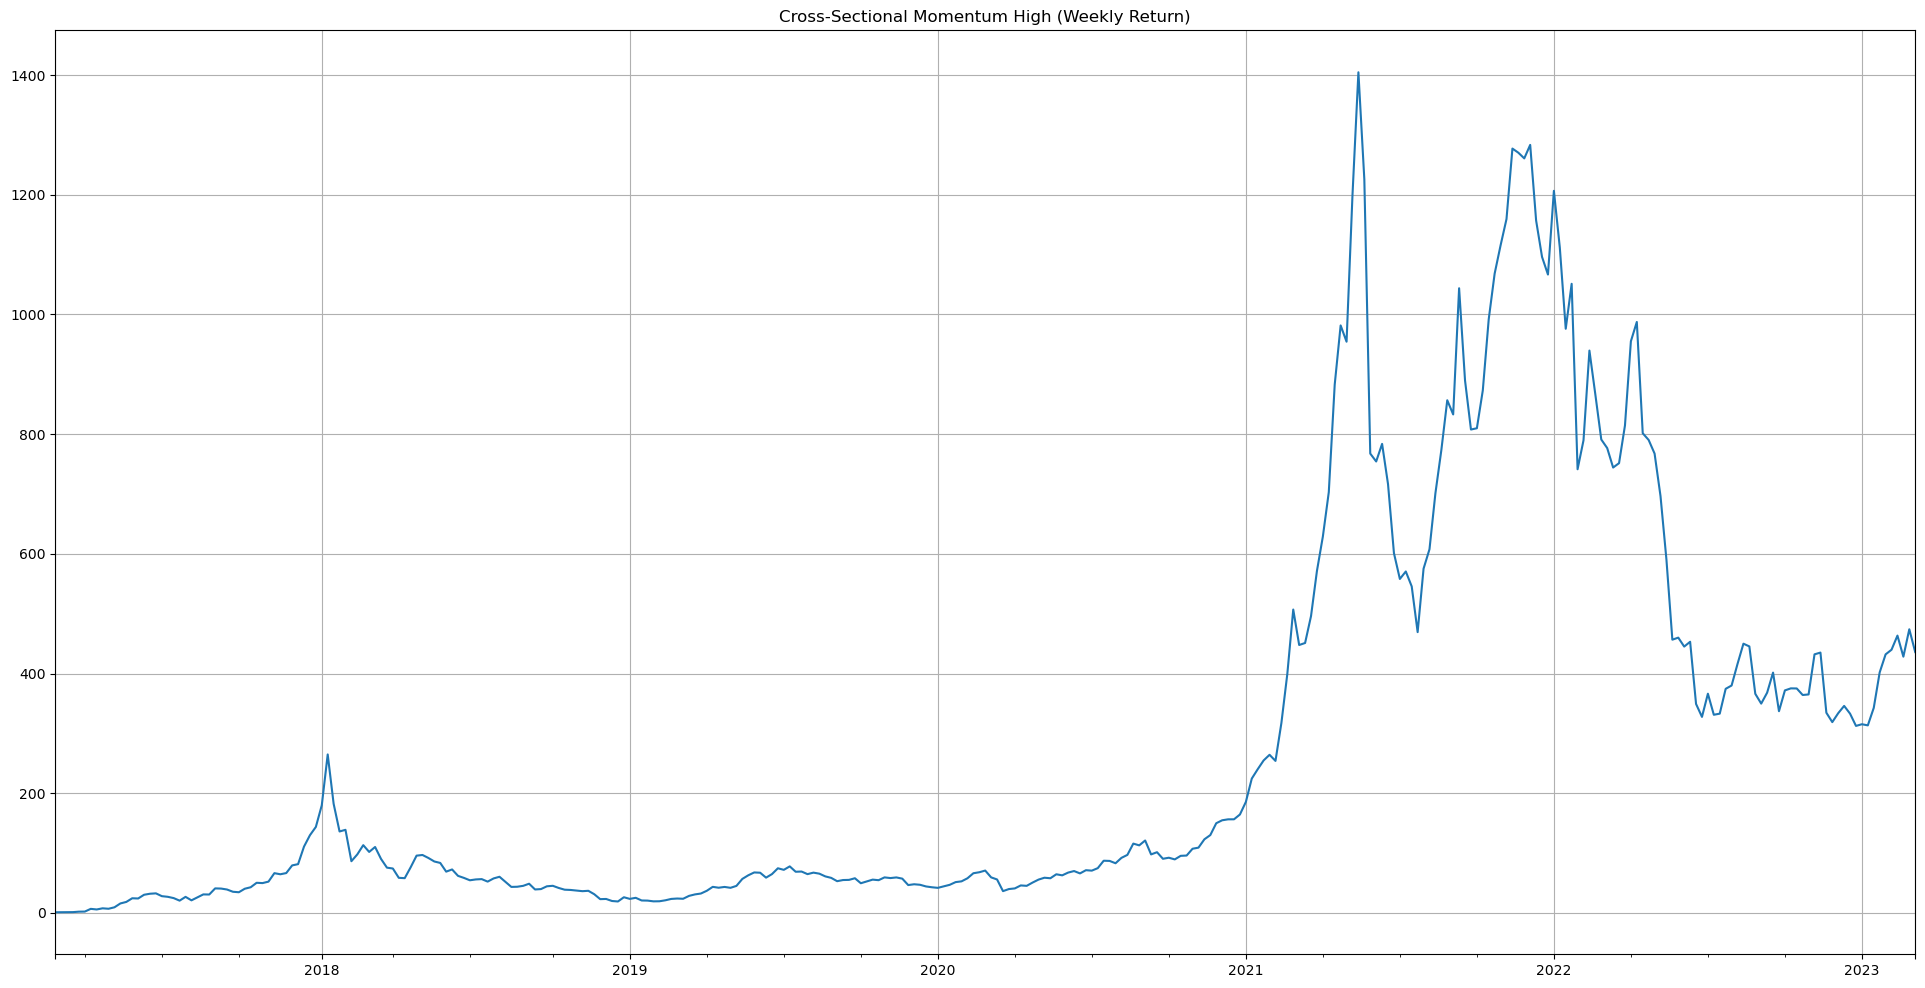

In [14]:
# 리턴 찍어보자
(rtn_h + 1).cumprod().plot(figsize=(24,12))
plt.title("Cross-Sectional Momentum High (Weekly Return)")
plt.grid();

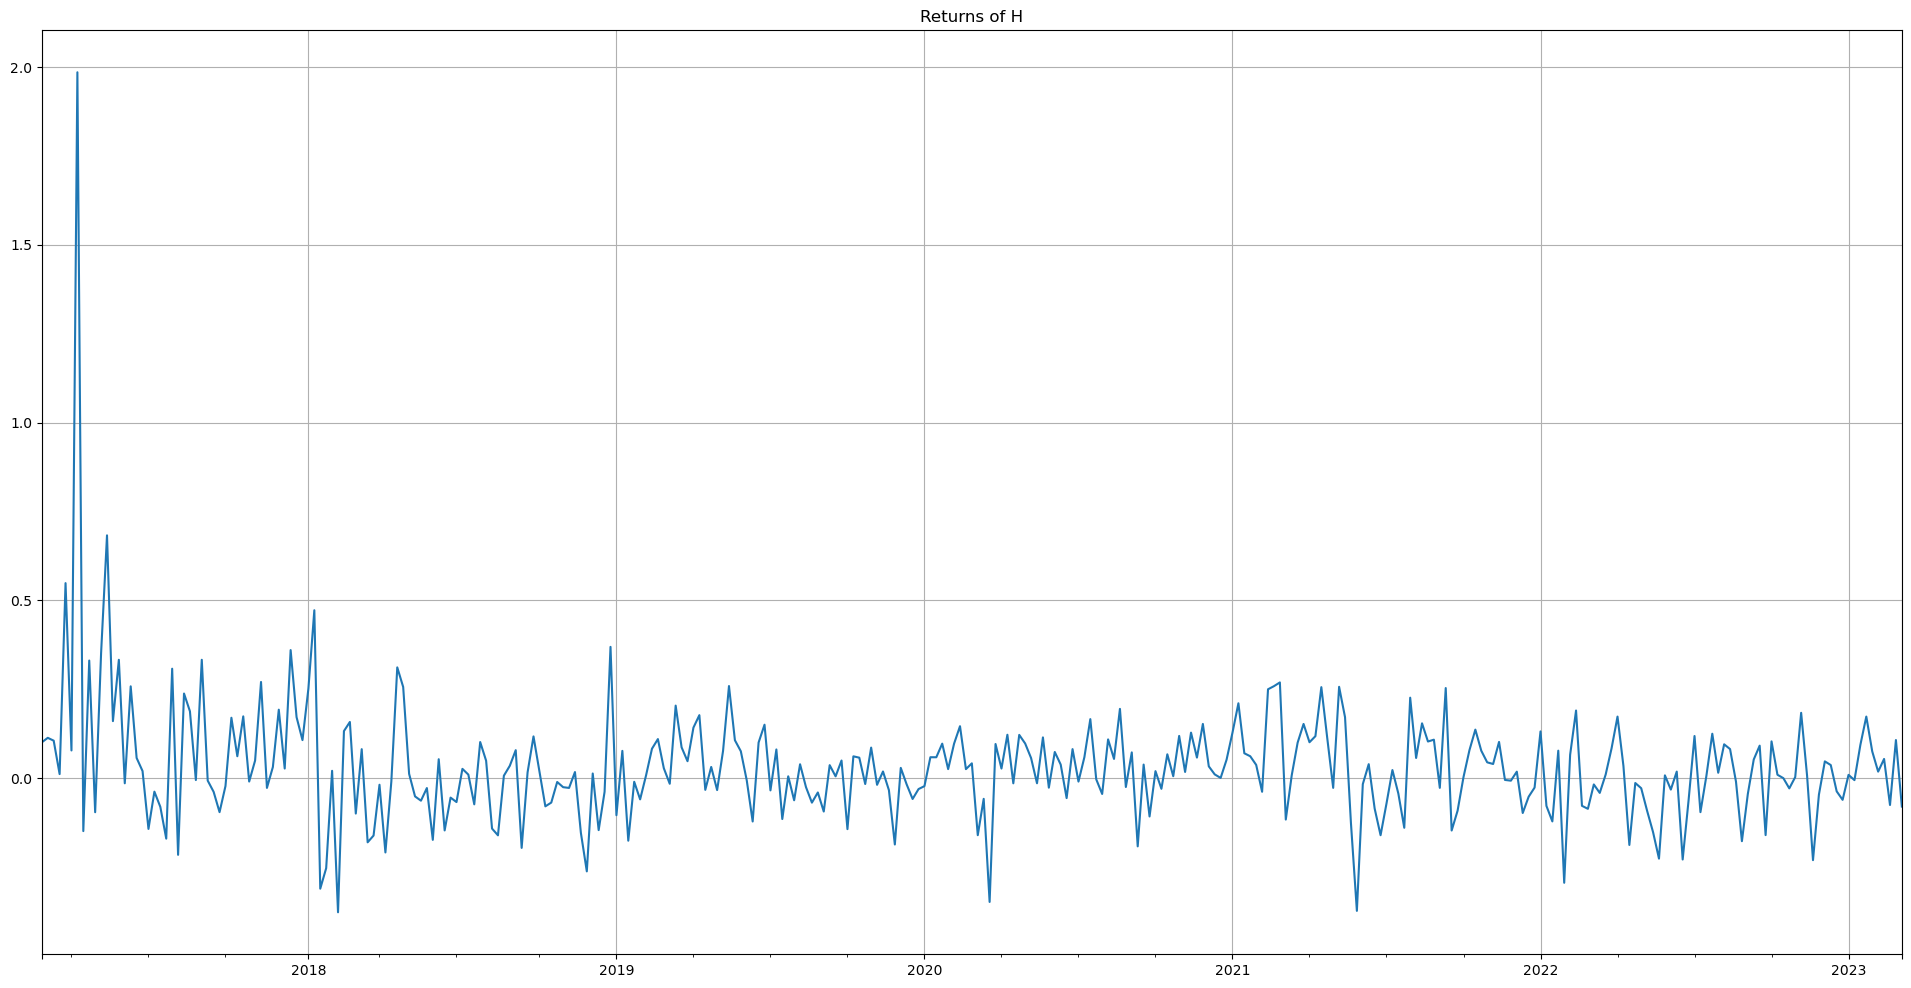

In [87]:
rtn_h.plot(figsize=(24,12))
plt.title("Returns of H")
plt.grid();

In [15]:
model = OLS(rtn5, 
            add_constant(result1.loc[start_date:] \
                                .iloc[:-1]))
model.fit().summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.664    
Dependent Variable: y                AIC:                -656.0485
Date:               2023-03-17 09:37 BIC:                -648.6210
No. Observations:   303              Log-Likelihood:     330.02   
Df Model:           1                F-statistic:        598.1    
Df Residuals:       301              Prob (F-statistic): 1.70e-73 
R-squared:          0.665            Scale:              0.0066734
---------------------------------------------------------------------
         Coef.     Std.Err.       t       P>|t|      [0.025    0.975]
---------------------------------------------------------------------
const    0.0036      0.0047     0.7689    0.4425    -0.0057    0.0129
0        1.0094      0.0413    24.4552    0.0000     0.9282    1.0907
------------------------------------------------------------------
Omnibus:              47.029       Durbin-Watson:          2.262  
Prob(Omnibus):        0.000        Jarque-Bera (JB):       175.330
Skew:                 0.595        Prob(JB):               0.000  
Kurtosis:             6.532        Condition No.:          9      
==================================================================

"""

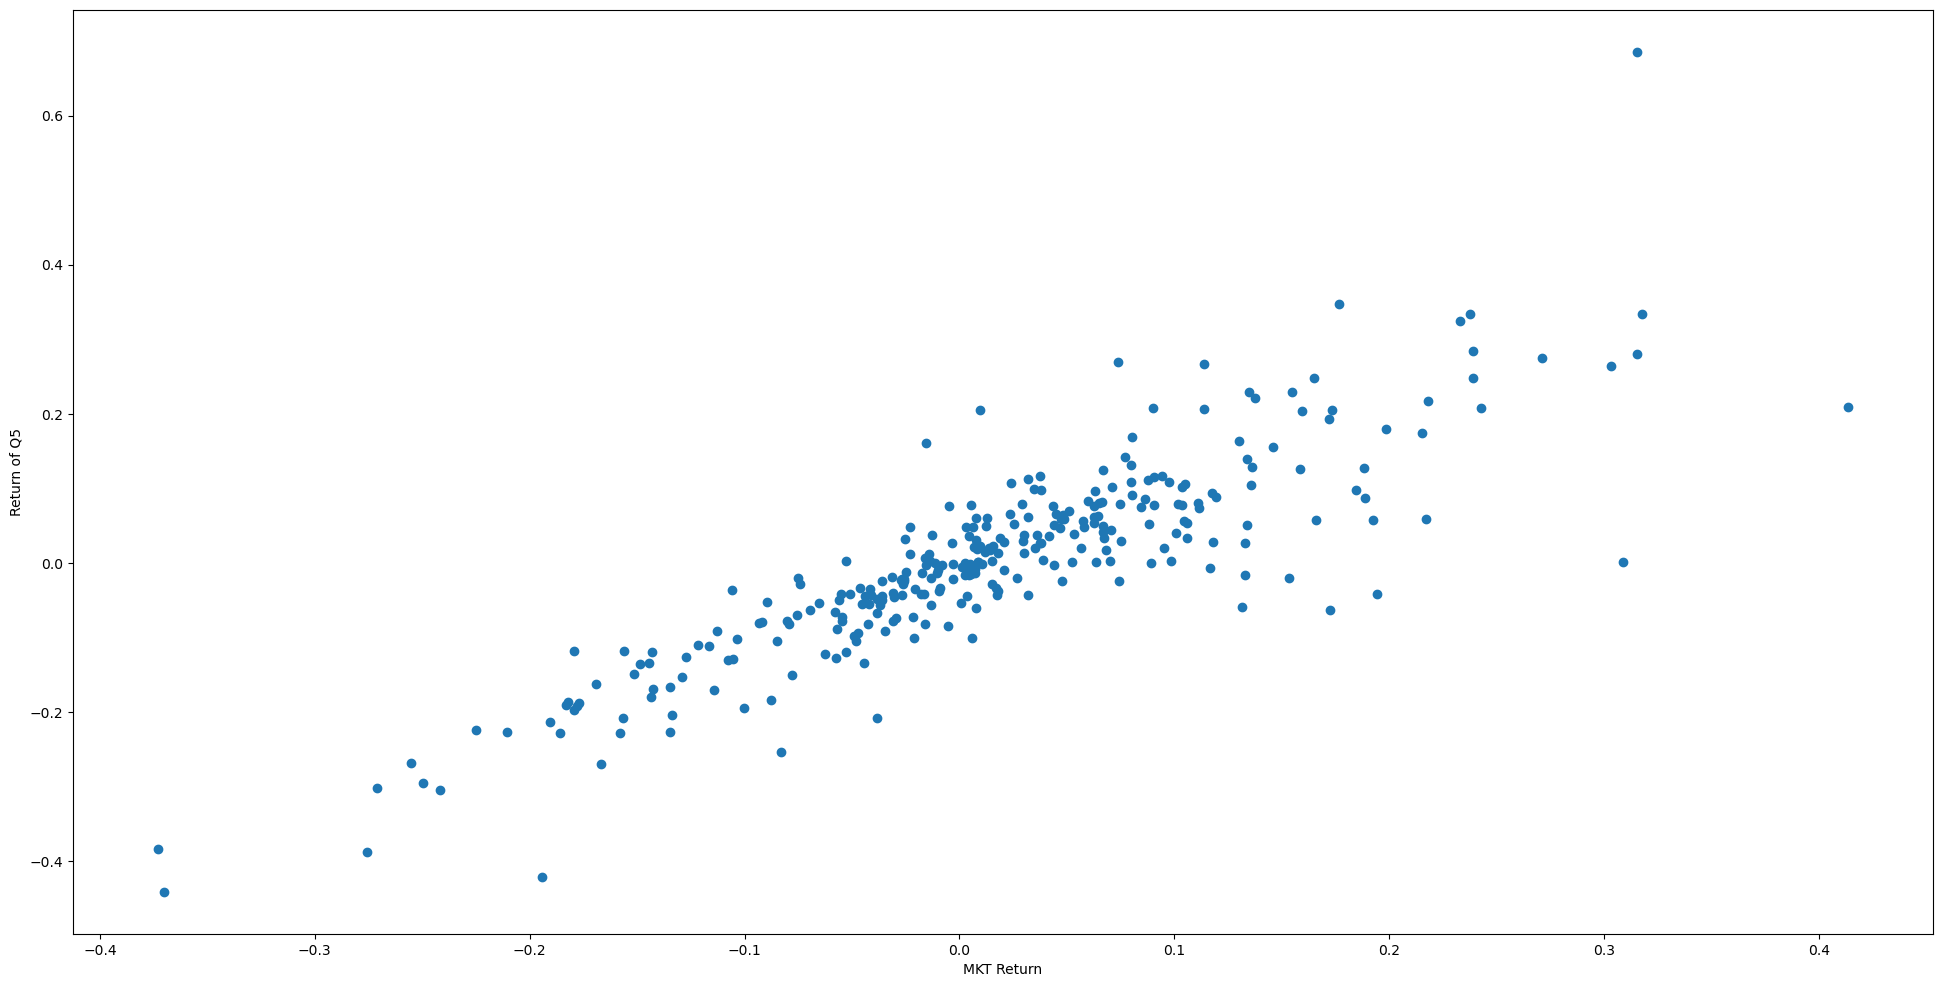

In [18]:
plt.figure(figsize=(24,12))
plt.scatter(result1.loc[start_date:].iloc[:-1],
            rtn2)
plt.xlabel("MKT Return")
plt.ylabel("Return of Q5");

In [58]:
model = OLS(rtn_s, 
            add_constant(result1.loc[start_date2:].iloc[:-1]))
model.fit().summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.735    
Dependent Variable: y                AIC:                -737.0117
Date:               2023-03-17 00:31 BIC:                -729.5065
No. Observations:   315              Log-Likelihood:     370.51   
Df Model:           1                F-statistic:        874.1    
Df Residuals:       313              Prob (F-statistic): 1.31e-92 
R-squared:          0.736            Scale:              0.0056060
--------------------------------------------------------------------
            Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
--------------------------------------------------------------------
const      -0.0179     0.0043   -4.2035   0.0000   -0.0263   -0.0095
0           1.0892     0.0368   29.5644   0.0000    1.0167    1.1617
------------------------------------------------------------------
Omnibus:              63.237       Durbin-Watson:          2.213  
Prob(Omnibus):        0.000        Jarque-Bera (JB):       510.936
Skew:                 0.531        Prob(JB):               0.000  
Kurtosis:             9.148        Condition No.:          9      
==================================================================

"""

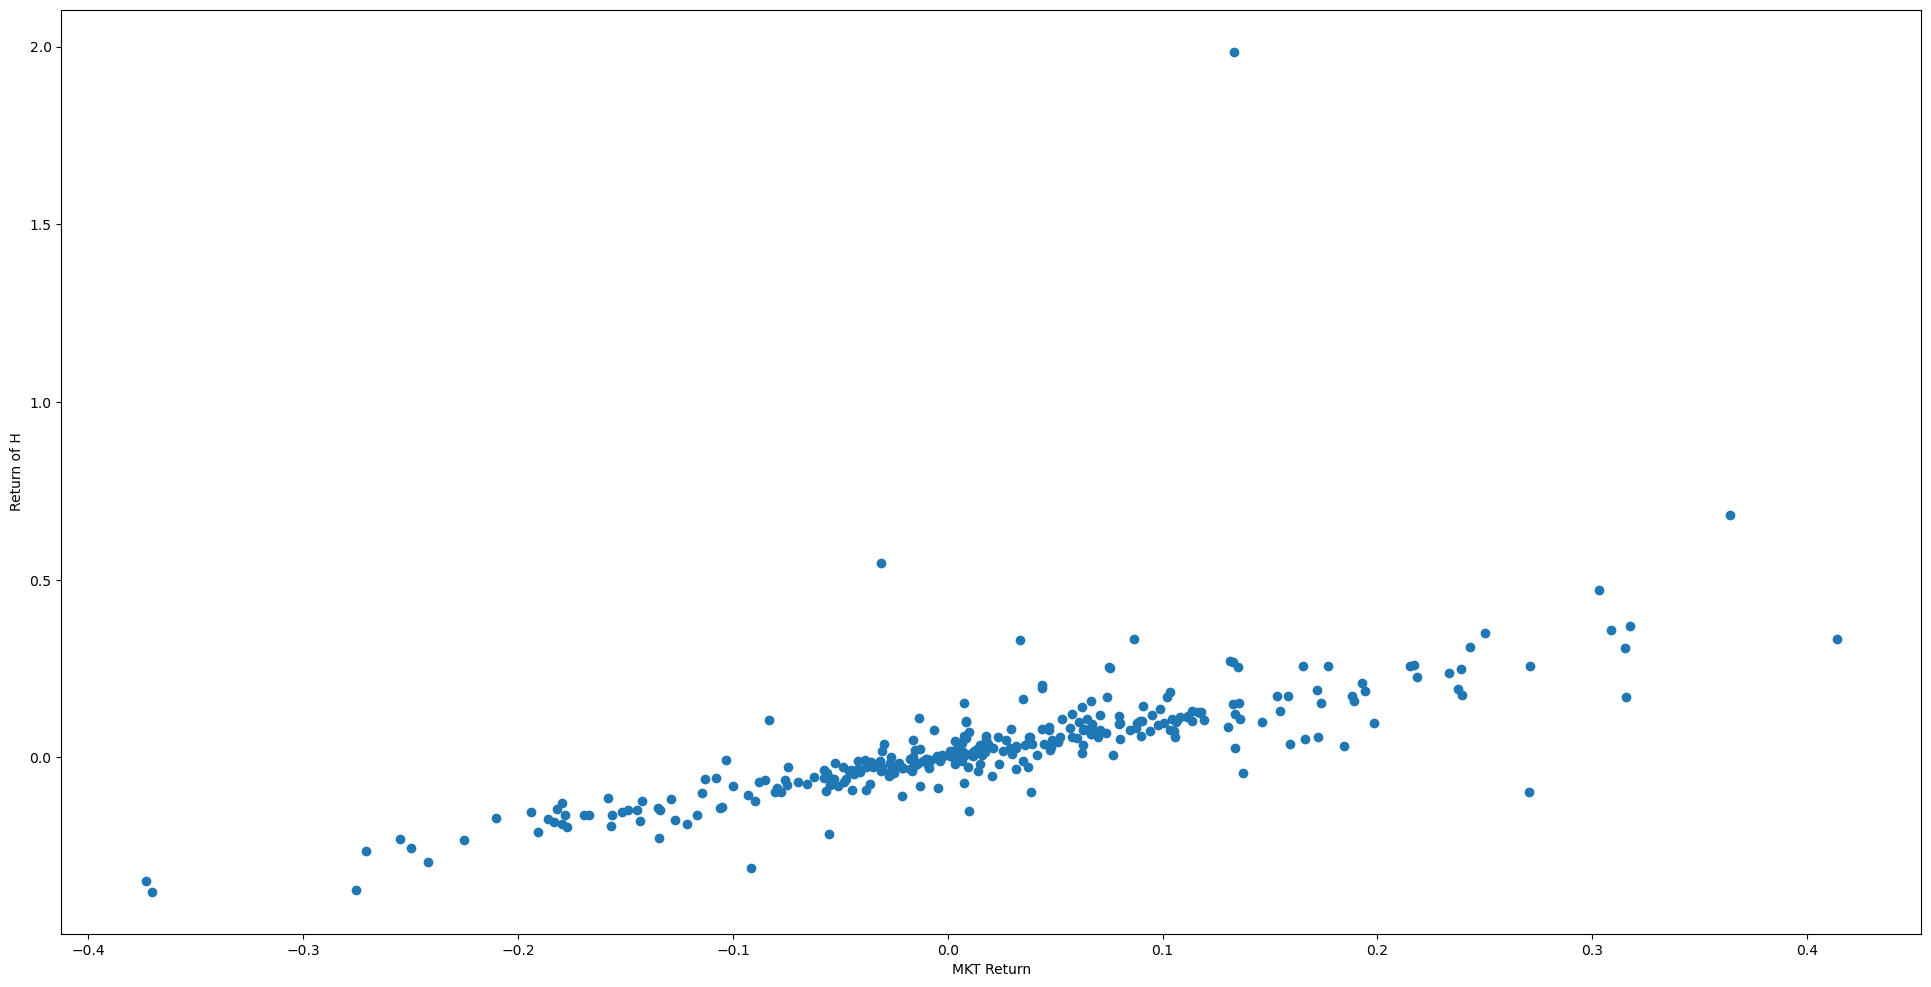

In [53]:
plt.figure(figsize=(24,12))
plt.scatter(result1.loc[start_date2:].iloc[:-1],
            rtn_h)
plt.xlabel("MKT Return")
plt.ylabel("Return of H");
#plt.ylim(-0.7,1.5);

In [20]:
mkt_sample = result1.loc[start_date:].iloc[:-1]

In [39]:
# 리턴이 통계적으로 다름을 보이기

# weekly MKT returns의 통계량
print("Coin MKT:", mkt_sample.mean(), mkt_sample.std())

# 5분위로 나눈 통계량
print("G1:", rtn1.mean().round(4), rtn1.std(ddof=1))
print("G2:", rtn2.mean().round(4), rtn2.std(ddof=1))
print("G3:", rtn3.mean().round(4), rtn3.std(ddof=1))
print("G4:", rtn4.mean().round(4), rtn4.std(ddof=1))
print("G5:", rtn5.mean().round(4), rtn5.std(ddof=1))

t, p_val = stats.ttest_ind(rtn4, rtn5, equal_var=False)
t, p_val

Coin MKT: 0.013635591451178574 0.11388260973077692
G1: 0.0059 0.21823059033870193
G2: 0.002 0.13228447264992055
G3: 0.0174 0.16014641933773902
G4: 0.0218 0.1394181723838901
G5: 0.0174 0.14094898508574077


C:\Users\user\AppData\Local\Temp\ipykernel_9152\2514867219.py:13: DeprecationWarning: Please use `ttest_ind` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  t, p_val = stats.ttest_ind(rtn4, rtn5, equal_var=False)


(0.38840220389717517, 0.6978552928550459)

In [40]:
def calculate_cagr(df):
    holding_year = (len(df) / 52)
    cum = (df+1).cumprod()
    cagr = (cum.iloc[-1] / cum.iloc[0]) ** (1/holding_year) -1
    print(f"The CAGR is {cagr:.2%}")
    return cagr

In [42]:
print("Market Return")
calculate_cagr(mkt_sample)

print("----------------")
print("Group Return")
calculate_cagr(rtn1)
calculate_cagr(rtn2)
calculate_cagr(rtn3)
calculate_cagr(rtn4)
calculate_cagr(rtn5)

Market Return
The CAGR is 42.87%
----------------
Group Return
The CAGR is -41.40%
The CAGR is -30.66%
The CAGR is 40.37%
The CAGR is 89.84%
The CAGR is 44.94%


0.44939461262830394

In [43]:
concat_df = pd.concat([rtn1, rtn2, rtn3, rtn4 , rtn5, mkt_sample], 
                      axis=1)
concat_df.columns = ["One","Two","Three","Four","Five","MKT"]

concat_df.corr()

,One,Two,Three,Four,Five,MKT
One,1.000000,0.738723,0.700725,0.629407,0.512541,0.704894
Two,0.738723,1.000000,0.717878,0.774463,0.697728,0.867341
Three,0.700725,0.717878,1.000000,0.712449,0.707691,0.833354
Four,0.629407,0.774463,0.712449,1.000000,0.693703,0.860007
Five,0.512541,0.697728,0.707691,0.693703,1.000000,0.815601
MKT,0.704894,0.867341,0.833354,0.860007,0.815601,1.000000


In [52]:
# 3개 그룹의 결과를 뽑자
mkt_sample2 = result1.loc[start_date2:].iloc[:-1]
rtn_s_sample = rtn_s.loc[start_date2:]
rtn_m_sample = rtn_m.loc[start_date2:]
rtn_h_sample = rtn_h.loc[start_date2:]

In [55]:
print("S:", rtn_s_sample.mean().round(4), rtn_s_sample.std(ddof=1))
print("M:", rtn_m_sample.mean().round(4), rtn_m_sample.std(ddof=1))
print("H:", rtn_h_sample.mean().round(4), rtn_h_sample.std(ddof=1))

S: 0.0001 0.1455778590630235
M: 0.019 0.13344664633880654
H: 0.0312 0.17556775520151072


In [56]:
print("Market Return")
calculate_cagr(mkt_sample2)

print("----------------")
print("Group Return")
calculate_cagr(rtn_s_sample)
calculate_cagr(rtn_m_sample)
calculate_cagr(rtn_h_sample)

Market Return
The CAGR is 65.74%
----------------
Group Return
The CAGR is -40.57%
The CAGR is 71.01%
The CAGR is 168.44%


1.6844319849405927

In [62]:
concat_df2 = pd.concat([rtn_s_sample, rtn_m_sample,
                        rtn_h_sample, mkt_sample2], 
                       axis=1)
concat_df2.columns = ["Low","Middle","High","MKT"]

concat_df2.corr()

,Low,Middle,High,MKT
Low,1.000000,0.805677,0.581542,0.858092
Middle,0.805677,1.000000,0.581143,0.902433
High,0.581542,0.581143,1.000000,0.709783
MKT,0.858092,0.902433,0.709783,1.000000


In [73]:
t, p_val = stats.ttest_ind(rtn_m_sample, 
                           rtn_h_sample)
t,p_val

C:\Users\user\AppData\Local\Temp\ipykernel_9152\990889301.py:1: DeprecationWarning: Please use `ttest_ind` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  t, p_val = stats.ttest_ind(rtn_m_sample,


(-0.9880956174963577, 0.32348636155138466)

In [66]:
model = OLS(rtn_h_sample, 
            add_constant(mkt_sample2))
                            
model.fit().summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.502    
Dependent Variable: y                AIC:                -419.8400
Date:               2023-03-17 09:53 BIC:                -412.3349
No. Observations:   315              Log-Likelihood:     211.92   
Df Model:           1                F-statistic:        317.8    
Df Residuals:       313              Prob (F-statistic): 1.49e-49 
R-squared:          0.504            Scale:              0.015344 
---------------------------------------------------------------------
         Coef.     Std.Err.       t       P>|t|      [0.025    0.975]
---------------------------------------------------------------------
const    0.0133      0.0071     1.8797    0.0611    -0.0006    0.0271
0        1.0865      0.0609    17.8265    0.0000     0.9666    1.2064
------------------------------------------------------------------
Omnibus:            573.608      Durbin-Watson:         2.045     
Prob(Omnibus):      0.000        Jarque-Bera (JB):      306100.063
Skew:               10.627       Prob(JB):              0.000     
Kurtosis:           154.229      Condition No.:         9         
==================================================================

"""

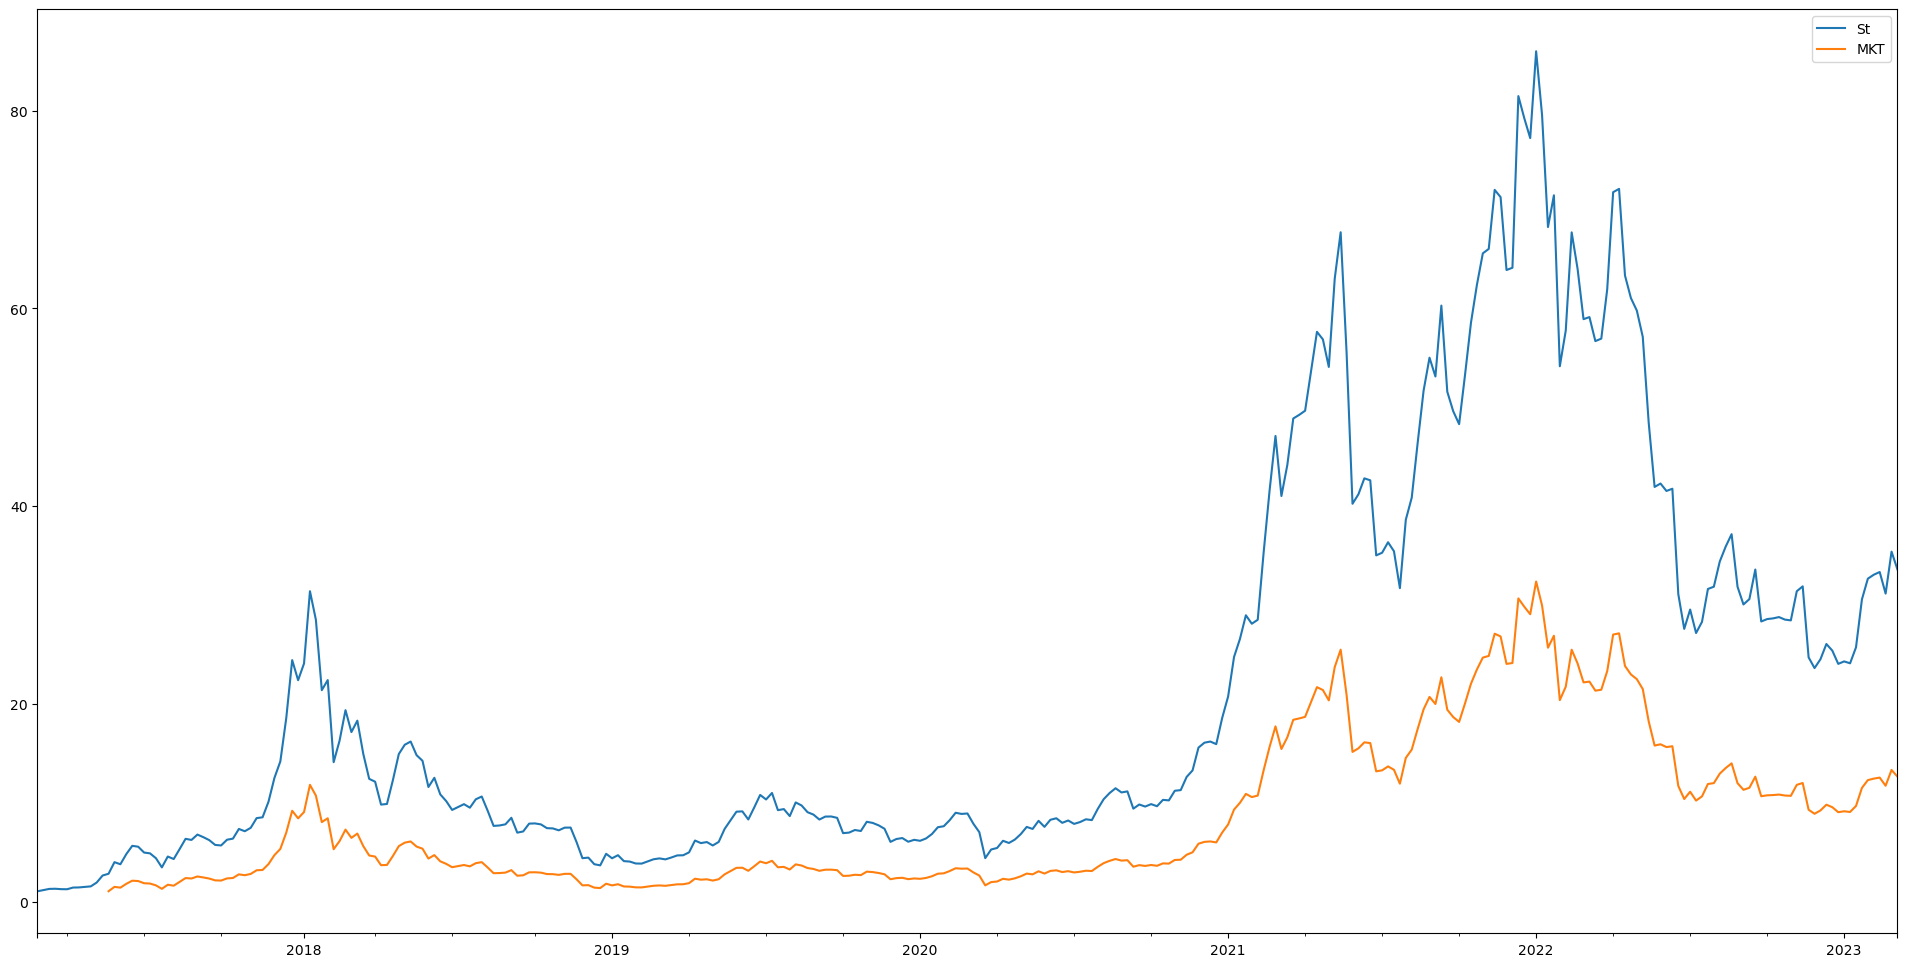

In [96]:
(result1.loc[start_date2:].iloc[:-1] +1)\
    .cumprod().plot(figsize=(24,12), label="Strategy")
(mkt_sample +1).cumprod().plot(figsize=(24,12),
                               label="MKT")
plt.legend();

* Long-Short 전략

코인 롱숏은 숏 한방을 얻어 맞고 죽는듯.....